# Biblioteca

In [13]:
import pandas as pd
import sklearn
import numpy as np
import statsmodels 
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import pydotplus
import graphviz

In [3]:
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style("whitegrid")
sns.set_palette("husl")

# Dados

In [4]:
dados_treino = pd.read_csv("porto_seguro_limpo_treino.csv")
dados_teste = pd.read_csv("porto_seguro_limpo_teste.csv")

In [70]:
# X_treino = dados_treino.drop(["id", "target"], 1)
# y_treino = dados_treino.loc[:, ["target"]]

# X_teste = dados_teste.drop(["id", "target"], 1)
# y_teste = dados_teste.loc[:, ["target"]]

# Balanceando dados

In [6]:
print(dados_treino.pipe(lambda x: x[x.target == 0]).shape)
print(dados_treino.pipe(lambda x: x[x.target == 1]).shape)

print(dados_teste.pipe(lambda x: x[x.target == 0]).shape)
print(dados_teste.pipe(lambda x: x[x.target == 1]).shape)

(401372, 72)
(15276, 72)
(172146, 72)
(6418, 72)


In [75]:
from imblearn.over_sampling import SMOTE

ros = SMOTE(ratio='minority')
X_treino, y_treino = ros.fit_resample(np.array(dados_treino.drop(["id", "target"], 1)),
                                      np.array(dados_treino.loc[:, ["target"]]))
X_treino = pd.DataFrame(X_treino).rename(columns=dict(zip(pd.DataFrame(X_treino).columns, 
                                                          dados_treino.drop(["id", "target"], 1).columns)))
y_treino = pd.DataFrame(y_treino).rename(columns=dict(zip(pd.DataFrame(y_treino).columns, 
                                                          dados_treino.loc[:, ["target"]].columns)))

X_teste, y_teste = ros.fit_resample(np.array(dados_teste.drop(["id", "target"], 1)),
                                      np.array(dados_teste.loc[:, ["target"]]))
X_teste = pd.DataFrame(X_teste).rename(columns=dict(zip(pd.DataFrame(X_teste).columns, 
                                                         dados_treino.drop(["id", "target"], 1).columns)))
y_teste = pd.DataFrame(y_teste).rename(columns=dict(zip(pd.DataFrame(y_teste).columns, 
                                                         dados_treino.loc[:, ["target"]].columns)))

# X_teste = dados_teste.drop(["id", "target"], 1)
# y_teste = dados_teste.loc[:, ["target"]]

## Previsão 

In [67]:
parametros_tunados = [{'max_depth': [5, 10, 20],
                       'min_samples_split': [3, 5, 7]}]

model = GridSearchCV(DecisionTreeClassifier(), parametros_tunados, cv=3, scoring='roc_auc')

## Resultados

In [9]:
result = model.fit(X_treino, y_treino)

auc = roc_auc_score(y_teste, result.predict_proba(X_teste)[:, 1])

print("Parâmetros escolhidos:")
print()
print(model.best_params_)
print()
print("Grid scores:")
print()
media = model.cv_results_['mean_test_score']
desv_pad = model.cv_results_['std_test_score']
for media, desv_pad, params in zip(media, desv_pad, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (media, desv_pad * 2, params))
print()
print("AUC: %.4f" % auc)

Parâmetros escolhidos:

{'max_depth': 20, 'min_samples_split': 7}

Grid scores:

0.875 (+/-0.038) for {'max_depth': 5, 'min_samples_split': 3}
0.875 (+/-0.038) for {'max_depth': 5, 'min_samples_split': 5}
0.875 (+/-0.038) for {'max_depth': 5, 'min_samples_split': 7}
0.964 (+/-0.044) for {'max_depth': 10, 'min_samples_split': 3}
0.964 (+/-0.044) for {'max_depth': 10, 'min_samples_split': 5}
0.964 (+/-0.044) for {'max_depth': 10, 'min_samples_split': 7}
0.972 (+/-0.043) for {'max_depth': 20, 'min_samples_split': 3}
0.974 (+/-0.044) for {'max_depth': 20, 'min_samples_split': 5}
0.975 (+/-0.046) for {'max_depth': 20, 'min_samples_split': 7}

AUC: 0.9696


In [76]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=7)
result = clf.fit(X_treino, y_treino)
predictions = result.predict_proba(X_teste)[:, 1]

In [77]:
from sklearn.metrics import roc_auc_score

acc = roc_auc_score(np.array(y_teste), predictions)
print("AUC na base de teste: %.4f" % acc) 
### valor anterior: 0.6197 --> é um ganho considerável, dado que o auc do vencedor da competição foi de 0,64849

AUC na base de teste: 0.8787


Text(0.5,0,'Importância relativa')

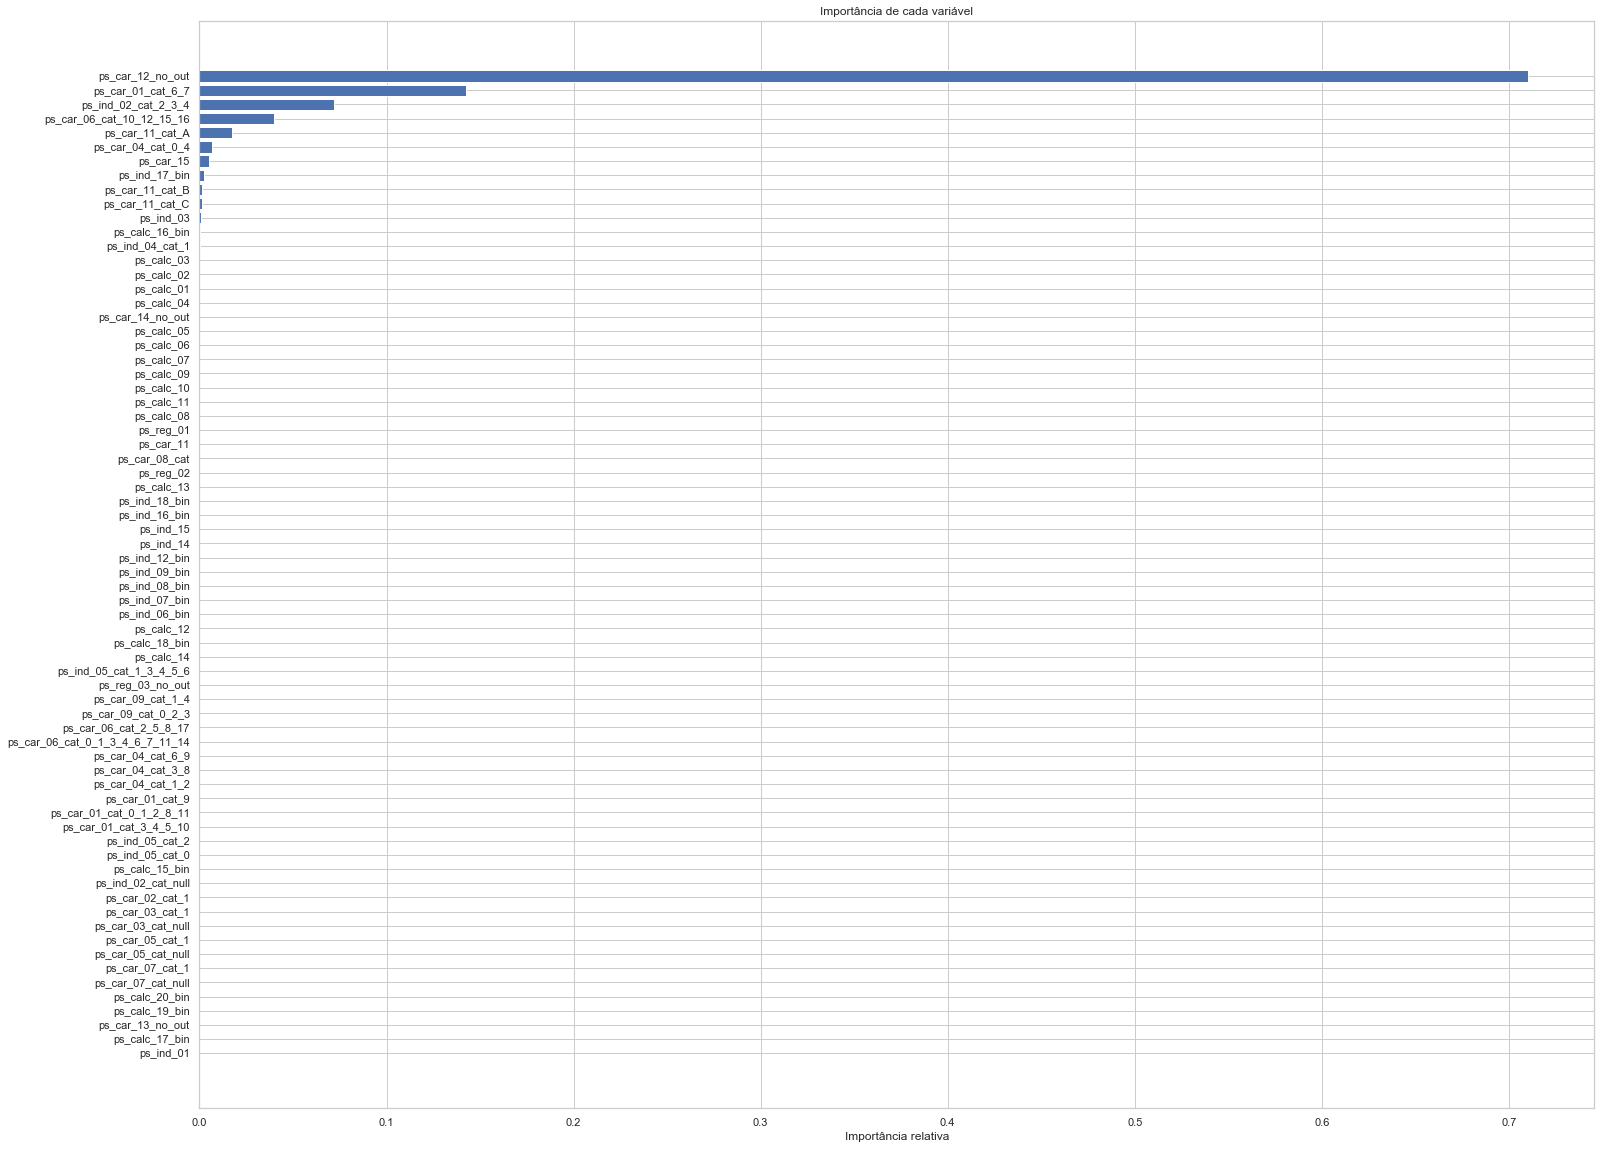

In [78]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(25,20)})
sns.set_style("whitegrid")
sns.set_palette("husl")


importances = clf.feature_importances_
indices = np.argsort(importances)
features = dados_treino.drop(["id", "target"], 1).columns

plt.figure(1)
plt.title('Importância de cada variável')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importância relativa')

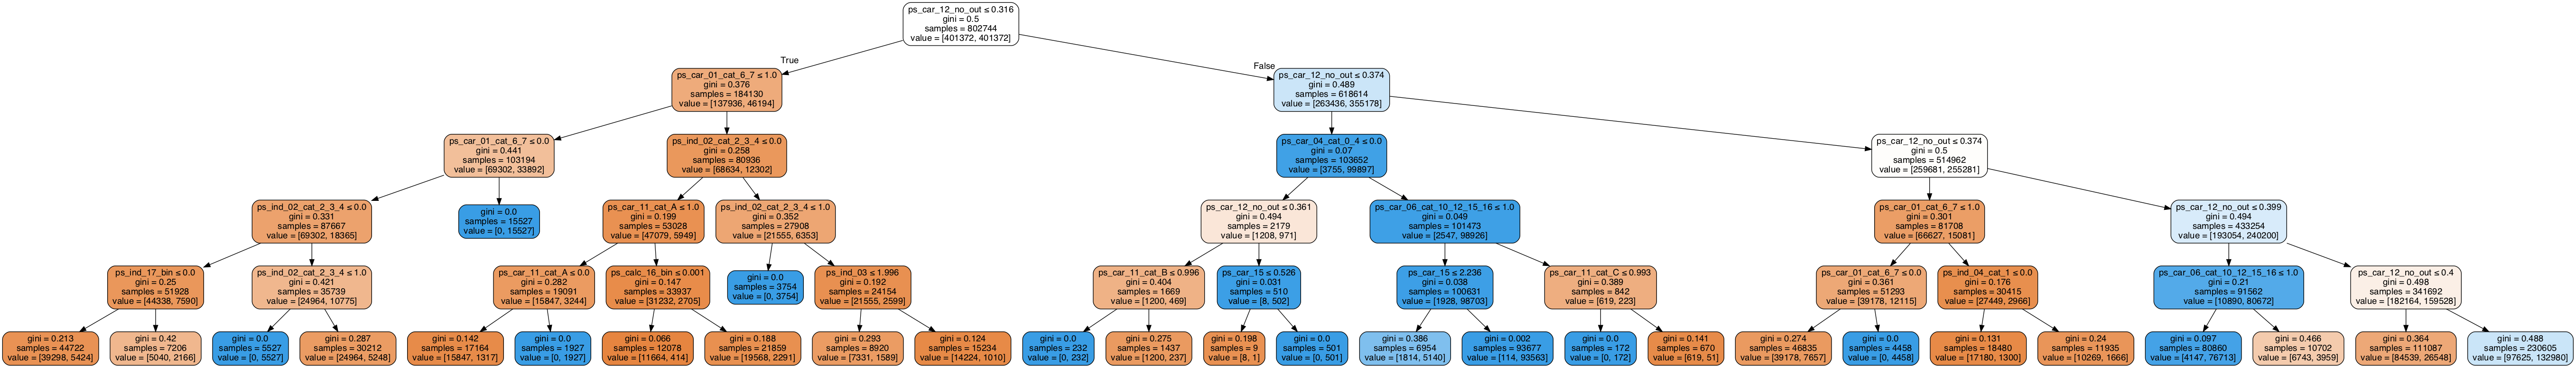

In [79]:
sns.set(rc={'figure.figsize':(50, 40)})
sns.set_style("whitegrid")
sns.set_palette("husl")

dot_data = tree.export_graphviz(clf, 
                                feature_names=dados_treino.drop(["id", "target"], 1).columns, 
                                filled=True, 
                                special_characters=True,
                                rounded=True,
                                out_file=None)

graph = pydotplus.graph_from_dot_data(dot_data) 

plt = Image(graph.create_png(), width=4000, height=3000)
display(plt)

In [ ]:
# # Create PDF
# graph.write_pdf("classification_tree_1.pdf")

# # Create PNG
# graph.write_png("classification_tree_1.png")

# Comentários

Como otimizar mais ainda os parâmetros tunados